In [40]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten, Conv2D, MaxPooling2D,BatchNormalization
from random import randrange

In [41]:
fake_path = 'training_fake'
real_path = 'training_real'
fake_ls =  os.listdir(fake_path)
real_ls = os.listdir(real_path)
print(fake_path, len(fake_ls))
print(real_path, len(real_ls))

training_fake 960
training_real 986


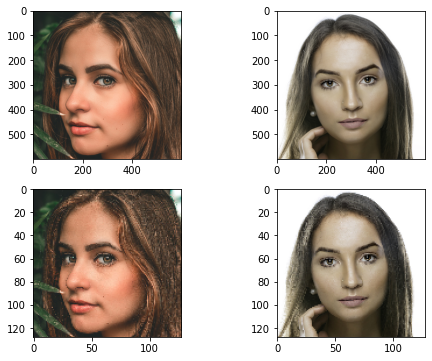

In [42]:
plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
plt.imshow(mpimg.imread(os.path.join(real_path, real_ls[0])))
plt.subplot(2, 2, 2)
plt.imshow(mpimg.imread(os.path.join(fake_path, fake_ls[0])))
plt.subplot(2, 2, 3)
plt.imshow(cv2.resize(mpimg.imread(os.path.join(real_path, real_ls[0])), (128, 128)))
plt.subplot(2, 2, 4)
plt.imshow(cv2.resize(mpimg.imread(os.path.join(fake_path, fake_ls[0])), (128, 128)))

In [43]:
img_size = int(128)

def random_rotate(img):
  r = randrange(4)
  if r == 0:
    return img
  elif r == 1:
    return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  elif r == 2:
    return cv2.rotate(img, cv2.ROTATE_180)
  else:
    return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

def create_training_data():
    x = []
    y = []
    for img in real_ls[:800]:
        path = os.path.join(real_path, img)
        image = cv2.resize(mpimg.imread(path), (img_size, img_size))
        image = random_rotate(image)
        x.append(np.array(image))
        y.append(1)
        
    for img in fake_ls[:800]:
        path = os.path.join(fake_path, img)
        image = cv2.resize(mpimg.imread(path), (img_size,img_size))
        image = random_rotate(image)
        x.append(np.array(image))  
        y.append(0)
        
    return(x,y)

def create_test_data():
    x = []
    y = []
    for img in real_ls[800:900]:
        path = os.path.join(real_path, img)
        image = cv2.resize(mpimg.imread(path), (img_size,img_size))
        image = random_rotate(image)
        x.append(np.array(image))
        y.append(1)
        
    for img in fake_ls[800:900]:
        path = os.path.join(fake_path, img)
        image = cv2.resize(mpimg.imread(path), (img_size,img_size))
        image = random_rotate(image)
        x.append(np.array(image))
        y.append(0)

    return(x,y)

X_train,Y_train = create_training_data()
X_test,Y_test= create_test_data()

In [44]:
X_train = np.array(X_train)/255.0
X_test = np.array(X_test)/255.0

In [45]:
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [46]:
model = Sequential()

model.add(Conv2D(
    64,     # 64 нейрона
    (3,3),  # фильтр с ядром 3х3
    input_shape=X_train.shape[1:]) # наследуем размерность от входных данных
)
# уплотнение группы 2х2 пикселей в целях уменьшить
# детальность изображения после выявления признаков
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation("relu")) 

model.add(Conv2D(32,(3,3)))  
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation("relu"))

model.add(Conv2D(16,(3,3))) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation("relu"))

# преобразование объемной матрицы
# в линейный вектор
model.add(Flatten()) 

model.add(Dense(128))
model.add(Activation("relu"))
# прореживание, убирающее нейрон с шансом 0.12
# для избегания переобучения модели
model.add(Dropout(0.12))


model.add(Dense(1)) 
model.add(Activation("sigmoid"))

# компилируем модель
model.compile(
    # ф-я потерь для бинарной классификации
    loss="binary_crossentropy",
    # алгоритм-оптимизатор с коэфф-ом обучения 0.001
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs = 10,
    validation_data=(X_test, Y_test)
)

Epoch 1/10
50/50 [==============================] - 49s 962ms/step - loss: 0.6976 - accuracy: 0.5081 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/10
50/50 [==============================] - 48s 954ms/step - loss: 0.6879 - accuracy: 0.5525 - val_loss: 0.6891 - val_accuracy: 0.5050
Epoch 3/10
50/50 [==============================] - 48s 953ms/step - loss: 0.6745 - accuracy: 0.5888 - val_loss: 0.6902 - val_accuracy: 0.5350
Epoch 4/10
50/50 [==============================] - 48s 951ms/step - loss: 0.6691 - accuracy: 0.5981 - val_loss: 0.6892 - val_accuracy: 0.6000
Epoch 5/10
50/50 [==============================] - 47s 948ms/step - loss: 0.6383 - accuracy: 0.6394 - val_loss: 0.6822 - val_accuracy: 0.5700
Epoch 6/10
50/50 [==============================] - 48s 950ms/step - loss: 0.6139 - accuracy: 0.6750 - val_loss: 0.7491 - val_accuracy: 0.5850
Epoch 7/10
50/50 [==============================] - 50s 991ms/step - loss: 0.5748 - accuracy: 0.6862 - val_loss: 0.7173 - val_accuracy: 0.5600

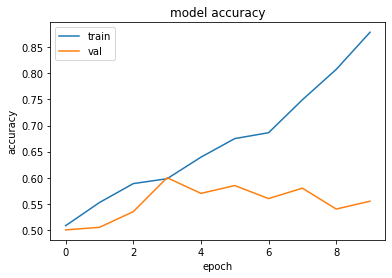

In [48]:
def plot_acc(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'])
  plt.show()

plot_acc(history)

In [49]:
model.evaluate(X_test,Y_test)

7/7 [==============================] - 1s 194ms/step - loss: 1.0018 - accuracy: 0.5550


[1.0018336772918701, 0.5550000071525574]

Epoch 1/10
50/50 [==============================] - 25s 498ms/step - loss: 0.6965 - accuracy: 0.4775 - val_loss: 0.6930 - val_accuracy: 0.5250
Epoch 2/10
50/50 [==============================] - 25s 496ms/step - loss: 0.6921 - accuracy: 0.5256 - val_loss: 0.6928 - val_accuracy: 0.5250
Epoch 3/10
50/50 [==============================] - 25s 495ms/step - loss: 0.6803 - accuracy: 0.5663 - val_loss: 0.6971 - val_accuracy: 0.5300
Epoch 4/10
50/50 [==============================] - 25s 497ms/step - loss: 0.6760 - accuracy: 0.5875 - val_loss: 0.6927 - val_accuracy: 0.5450
Epoch 5/10
50/50 [==============================] - 25s 498ms/step - loss: 0.6625 - accuracy: 0.6162 - val_loss: 0.7001 - val_accuracy: 0.5550
Epoch 6/10
50/50 [==============================] - 25s 495ms/step - loss: 0.6343 - accuracy: 0.6350 - val_loss: 0.7201 - val_accuracy: 0.5600
Epoch 7/10
50/50 [==============================] - 25s 496ms/step - loss: 0.6049 - accuracy: 0.6712 - val_loss: 0.7135 - val_accuracy: 0.5150

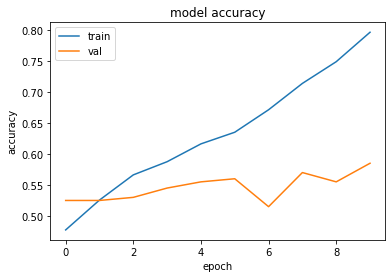

7/7 [==============================] - 1s 108ms/step - loss: 0.8355 - accuracy: 0.5850


[0.8355048894882202, 0.5849999785423279]

In [50]:
model = Sequential()

model.add(Conv2D(32,(3,3), input_shape=X_train.shape[1:])) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation("relu")) 

model.add(Conv2D(16,(3,3)))  
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation("relu"))

model.add(Conv2D(8,(3,3))) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation("relu"))

model.add(Flatten()) 

model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.12))


model.add(Dense(1)) 
model.add(Activation("sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs = 10,
    validation_data=(X_test, Y_test)
)

plot_acc(history)

model.evaluate(X_test,Y_test)

Epoch 1/10
50/50 [==============================] - 24s 477ms/step - loss: 0.6987 - accuracy: 0.5256 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 2/10
50/50 [==============================] - 24s 472ms/step - loss: 0.6923 - accuracy: 0.5475 - val_loss: 0.6961 - val_accuracy: 0.4950
Epoch 3/10
50/50 [==============================] - 24s 474ms/step - loss: 0.6843 - accuracy: 0.5731 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 4/10
50/50 [==============================] - 24s 473ms/step - loss: 0.6644 - accuracy: 0.6025 - val_loss: 0.7414 - val_accuracy: 0.5500
Epoch 5/10
50/50 [==============================] - 24s 475ms/step - loss: 0.6313 - accuracy: 0.6506 - val_loss: 0.7210 - val_accuracy: 0.5350
Epoch 6/10
50/50 [==============================] - 24s 477ms/step - loss: 0.5929 - accuracy: 0.6812 - val_loss: 0.7321 - val_accuracy: 0.5550
Epoch 7/10
50/50 [==============================] - 24s 475ms/step - loss: 0.5461 - accuracy: 0.7275 - val_loss: 0.7537 - val_accuracy: 0.5350

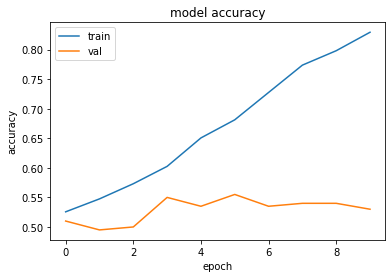

7/7 [==============================] - 1s 103ms/step - loss: 0.8050 - accuracy: 0.5300


[0.8050275444984436, 0.5299999713897705]

In [51]:
model = Sequential()

model.add(Conv2D(32,(3,3), input_shape=X_train.shape[1:])) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation("relu")) 

model.add(Conv2D(16,(3,3)))  
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation("relu"))

#model.add(Conv2D(8,(3,3))) 
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Activation("relu"))

model.add(Flatten()) 

#model.add(Dense(64))
#model.add(Activation("relu"))
#model.add(Dropout(0.12))


model.add(Dense(1)) 
model.add(Activation("sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs = 10,
    validation_data=(X_test, Y_test)
)

plot_acc(history)

model.evaluate(X_test,Y_test)